In [15]:
import backtrader as bt
import datetime
import pandas as pd
import math
import traceback
import matplotlib.pyplot as plt

import numpy as np
import tushare as ts
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D  #绘制三D图形

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm.notebook import tqdm # , tnrange, tqdm_notebook

import pymongo
from pymongo import MongoClient

In [2]:
from lutils.stock import LTdxHq

In [3]:
# 获取股票基本信息，包括 PE、PB 值
ts.set_token('42731ca565c5d019007ef5cd7db7808757b2ea3fdbfb31d4f7b61444b')
pro = ts.pro_api()

df_base = pro.stock_basic() # ts.get_stock_basics()
# df_base['code'] = df_base.index

# 获取股票当天数据，包括当前股价
df_todays = ts.get_today_all()
# df_todays['code'] = df_todays.index

df_roe = ts.get_report_data(2021, 3)
# df_roe['code'] = df_roe.index

[Getting data:]#################################################本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
[Getting data:]############################################################################

In [4]:
df_base['code'] = df_base['ts_code'].str.slice(stop=-3)
df_roe = df_roe.drop_duplicates()

In [130]:
df.columns

Index(['code', 'name_x', 'changepercent', 'trade', 'open', 'high', 'low',
       'settlement', 'volume', 'turnoverratio', 'amount', 'per', 'pb',
       'mktcap', 'nmc', 'ts_code', 'symbol', 'name_y', 'area', 'industry',
       'market', 'list_date', 'name', 'eps', 'eps_yoy', 'bvps', 'roe', 'epcf',
       'net_profits', 'profits_yoy', 'distrib', 'report_date'],
      dtype='object')

In [72]:
# 整合股价与 PE、PB 数据
df = pd.merge(df_todays, df_base, how='left', on=['code'])
df = pd.merge(df, df_roe, how='left', on=['code'])

# df.dropna()
result = df[(0 < df['pb']) 
            & (df['pb'] < 8) 
            & (-20 < df['roe']) 
            & (df['roe'] < 30) 
            & (0 < df['trade']) 
            & (df['trade'] < 70)
            & (-100 < df['per'])
            & (df['per'] < 200)]

# X = result[['pb', 'roe', 'trade', 'code', 'industry', 'market']]

In [75]:
result = pd.merge(result, ddd, how='left', on=['code'])

In [87]:
result.columns

Index(['code', 'name_x', 'changepercent', 'trade', 'open', 'high', 'low',
       'settlement', 'volume', 'turnoverratio', 'amount', 'per', 'pb',
       'mktcap', 'nmc', 'ts_code', 'symbol', 'name_y', 'area', 'industry',
       'market', 'list_date', 'name', 'eps', 'eps_yoy', 'bvps', 'roe', 'epcf',
       'net_profits', 'profits_yoy', 'distrib', 'report_date', 'value'],
      dtype='object')

In [122]:
result.turnoverratio

0       0.65623
1       5.01776
2       3.65775
3       2.94324
4       1.57854
         ...   
2407    0.39170
2408    0.14344
2409    0.14080
2410    0.13985
2411    0.52311
Name: turnoverratio, Length: 2412, dtype: float64

In [115]:
# result.to_pickle('d:/d.pkl')

In [123]:
columns = ['turnoverratio', 'nmc', 'net_profits'] # ['pb', 'roe', 'trade'] ['pb', 'roe', 'per']

In [124]:
scaler = MinMaxScaler()
scaler.fit(result[columns])
X = pd.DataFrame(scaler.transform(result[columns]), columns=columns)

In [125]:
# kmeans = KMeans(n_clusters=10)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

model = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', assign_labels='kmeans')
# model = DBSCAN(eps=0.6, min_samples=10)
# model = AffinityPropagation(random_state=5)
y_kmeans = model.fit_predict(X[columns])

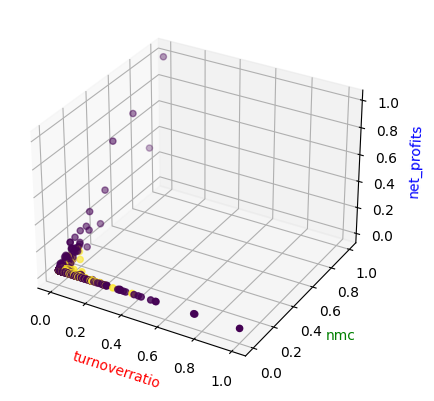

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X = result['pb'].tolist() # X 轴为 PB 数据 
# Y = result['roe'].tolist()
# Z = result['trade'].tolist() # Z 轴为 股价数据 

ax.set_xlabel(columns[0], color='r')
ax.set_ylabel(columns[1], color='g')
ax.set_zlabel(columns[2], color='b') # 给三个坐标轴注明

ax.scatter(X[columns[0]], X[columns[1]], X[columns[2]], c=pd.to_numeric(result['value']) > 11000) # ==6)

plt.show()

In [10]:
client = MongoClient()
db = client['quantaxis']
coll_min = db['stock_min']

In [28]:
def init_data_mongo(code):
    df= pd.DataFrame(list(coll_min.find({'$and': [
        {'code': {'$eq': code}}, 
        {'type': {'$eq': '15min'}}, 
        {'date': {'$gte': '2021-01-01'}}]})))
    df = df.drop(columns=['_id', 'date_stamp', 'time_stamp', 'type', 'date'])
    return df.set_index([pd.to_datetime(df['datetime'])])

In [12]:
def init_data(code):
    ltdxhq = LTdxHq()
    df15 = ltdxhq.get_k_data_15min(code, qfq=True, start='2021-01-01') #' # 000032 300142 603636 600519
#     df60 = ltdxhq.get_k_data_1hour(code, qfq=True) #' # 000032 300142 603636 600519
#     df1d = ltdxhq.get_k_data_daily(code, qfq=True) #' # 000032 300142 603636 600519
    
    df15.index = df15.index.unique(level=1)
#     df60.index = df60.index.unique(level=1)
#     df1d.index = df1d.index.unique(level=0)
    ltdxhq.close()
    
    data15 = df15 # df15['2021-01-01':]
#     data60 = df60['2021-01-01':]
#     data1d = df1d['2021-01-01':]
    return data15 # , data60, dfdata1d1d

In [13]:
class MultiTFStrategy(bt.Strategy):
    params = (
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
        
        ('short', 30),
        ('long', 70),
    )
    
    # states defination
    Empty, M15Hold, H1Hold, D1Hold = range(4)
    States = [
        'Empty', 'M15Hold', 'H1Hold', 'D1Hold',
    ]
    
    def log(self, txt):
        ''' Logging function for this strategy'''
        dt = self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):

        self.rsi15 = bt.indicators.RSI_EMA(self.dnames.hs15m.close, period=14) # RSI_SMA
        self.rsi60 = bt.indicators.RSI_EMA(self.dnames.hs1h.close, period=14)
        self.rsi1d = bt.indicators.RSI_EMA(self.dnames.hs1d.close, period=14)
    
        self.st = self.Empty
        self.st_map = {
            self.Empty: self._empty,
            self.M15Hold: self._m15hold,
            self.H1Hold: self._h1hold,
            self.D1Hold: self._d1hold,
        }
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status == order.Completed:
            if order.isbuy():
#                 self.log(
#                     'BUY EXECUTED, St: %s, Size: %d, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                     (
#                         self.States[self.st],
#                         order.executed.size,
#                         order.executed.price,
#                         order.executed.value,
#                         order.executed.comm,
#                     )
#                 )
                pass
            else:  # Sell
#                 self.log(
#                     'SELL EXECUTED, St: %s, Size: %d, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                     (
#                         self.States[self.st],
#                         order.executed.size,
#                         order.executed.price,
#                         order.executed.value,
#                         order.executed.comm
#                     )
#                 )
                pass
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
#             self.log('Order Canceled/Margin/Rejected')
            pass

        # Write down: no pending order
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

#         self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # just call state_map function
        self.order = self.st_map[self.st]()
        
        # Check if we are in the market and no buy order issued
        if self.position and not self.order:
            # Already in the market ... we might sell
            if self.rsi1d > self.params.long:
                self.st = self.Empty
                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
                
    def _empty(self):
        if self.rsi15 < self.params.short:
            price = self.data0.close[0]
            cash = self.broker.get_cash()
            # 20% of the cash
            share = int(math.floor((0.2*cash)/price))

            # set state
            self.st = self.M15Hold
            return self.buy(size=share)
        
    def _m15hold(self):
        if self.rsi60 < self.params.short:
            price = self.data0.close[0]
            cash = self.broker.get_cash()
            # half of the remain cash ( 60% )
            share = int(math.floor((0.6*cash)/price))
            
            # set state
            self.st = self.H1Hold
            return self.buy(size=share)
        
    def _h1hold(self):
        if self.rsi1d < self.params.short:
            price = self.data0.close[0]
            cash = self.broker.get_cash()
            # half of the remain cash (80%)
            share = int(math.floor((0.8*cash)/price))
            
            # set state
            self.st = self.D1Hold
            return self.buy(size=share)
        
    def _d1hold(self):
        return None

In [30]:
back_list = {}
for code in tqdm(result.code): # result[y_kmeans==6].code):
    try:
        data15 = init_data_mongo(code)

        cerebro = bt.Cerebro(oldtrades=True)

        # feed15 = bt.feeds.PandasData(dataname=data15, openinterest=None, compression=15, timeframe=bt.TimeFrame.Minutes)
        # feed60 = bt.feeds.PandasData(dataname=data60, openinterest=None, compression=60, timeframe=bt.TimeFrame.Minutes)
        # feed1d = bt.feeds.PandasData(dataname=data1d, openinterest=None, compression=1, timeframe=bt.TimeFrame.Days)

        # cerebro.adddata(feed15, name='hs15m')
        # cerebro.adddata(feed60, name='hs1h')
        # cerebro.adddata(feed1d, name='hs1d')

        feed = bt.feeds.PandasData(dataname=data15, openinterest=None, compression=15, timeframe=bt.TimeFrame.Minutes)
        cerebro.adddata(feed, name='hs15m')
        cerebro.resampledata(feed, name='hs1h', timeframe=bt.TimeFrame.Minutes, compression=60)
        cerebro.resampledata(feed, name='hs1d', timeframe=bt.TimeFrame.Days)

        cerebro.addstrategy(MultiTFStrategy)

        # 小场面1万起始资金
        cerebro.broker.setcash(10000.0)
        # 手续费万5
        cerebro.broker.setcommission(0.0005)

    #     print('%s Starting Portfolio Value: %.2f' % (code, cerebro.broker.getvalue()))
    #     result = cerebro.run()
        cerebro.run()
        print('%s Final Portfolio Value: %.2f' % (code, cerebro.broker.getvalue()))

        back_list[code] = cerebro.broker.getvalue()
    except Exception as ex:
        print('%s Error' % code)
        back_list[code] = 10000

  0%|          | 0/2572 [00:00<?, ?it/s]

688981 Final Portfolio Value: 10452.31
688819 Final Portfolio Value: 11415.85
688722 Final Portfolio Value: 10000.00
688701 Final Portfolio Value: 9008.62
688698 Final Portfolio Value: 15347.39
688697 Final Portfolio Value: 9634.04
688689 Final Portfolio Value: 14179.85
688681 Final Portfolio Value: 9681.19
688679 Final Portfolio Value: 9302.94
688678 Final Portfolio Value: 14655.84
688660 Final Portfolio Value: 14891.27
688656 Final Portfolio Value: 9353.24
688626 Final Portfolio Value: 7238.47
688616 Final Portfolio Value: 9326.85
688609 Final Portfolio Value: 9989.02
688607 Final Portfolio Value: 9466.95
688600 Final Portfolio Value: 11443.50
688588 Final Portfolio Value: 7375.90
688586 Final Portfolio Value: 11486.35
688579 Final Portfolio Value: 9488.07
688578 Final Portfolio Value: 13308.75
688575 Final Portfolio Value: 5175.78
688571 Final Portfolio Value: 9605.35
688569 Final Portfolio Value: 9651.78
688565 Final Portfolio Value: 8737.03
688558 Final Portfolio Value: 13909.23
6

603816 Final Portfolio Value: 9052.99
603813 Final Portfolio Value: 10455.64
603811 Final Portfolio Value: 6738.29
603809 Final Portfolio Value: 12447.28
603797 Final Portfolio Value: 9804.73
603790 Final Portfolio Value: 10438.41
603789 Final Portfolio Value: 9846.90
603788 Final Portfolio Value: 9951.91
603787 Final Portfolio Value: 6393.44
603777 Final Portfolio Value: 11138.00
603773 Final Portfolio Value: 9048.22
603768 Final Portfolio Value: 10405.05
603767 Final Portfolio Value: 11227.06
603759 Error
603758 Final Portfolio Value: 10073.39
603757 Final Portfolio Value: 10216.86
603755 Final Portfolio Value: 7304.18
603739 Final Portfolio Value: 10658.77
603733 Final Portfolio Value: 13150.03
603730 Final Portfolio Value: 8677.26
603729 Final Portfolio Value: 8361.63
603728 Final Portfolio Value: 11346.06
603725 Final Portfolio Value: 8392.36
603722 Final Portfolio Value: 13676.96
603717 Final Portfolio Value: 13953.91
603716 Final Portfolio Value: 9956.92
603711 Final Portfolio V

603050 Final Portfolio Value: 17730.58
603048 Error
603045 Final Portfolio Value: 15778.18
603043 Final Portfolio Value: 6444.15
603041 Final Portfolio Value: 9482.57
603040 Final Portfolio Value: 7893.28
603038 Final Portfolio Value: 14017.30
603037 Final Portfolio Value: 13869.25
603036 Final Portfolio Value: 10905.59
603033 Final Portfolio Value: 9162.87
603030 Final Portfolio Value: 8297.32
603029 Final Portfolio Value: 12649.36
603028 Final Portfolio Value: 9841.45
603023 Final Portfolio Value: 11045.09
603022 Final Portfolio Value: 12692.59
603019 Final Portfolio Value: 8754.76
603016 Final Portfolio Value: 10832.08
603009 Final Portfolio Value: 11084.46
603008 Final Portfolio Value: 14511.37
603007 Final Portfolio Value: 9326.14
603006 Final Portfolio Value: 12169.67
603005 Final Portfolio Value: 7724.06
603002 Final Portfolio Value: 12943.18
603001 Final Portfolio Value: 11395.54
603000 Final Portfolio Value: 8605.78
601999 Final Portfolio Value: 9382.78
601992 Final Portfolio 

600844 Final Portfolio Value: 7990.61
600843 Final Portfolio Value: 11065.08
600837 Final Portfolio Value: 9996.97
600836 Final Portfolio Value: 12279.21
600835 Final Portfolio Value: 7889.03
600834 Final Portfolio Value: 11509.92
600833 Final Portfolio Value: 8873.55
600831 Final Portfolio Value: 9065.07
600830 Final Portfolio Value: 9908.09
600829 Final Portfolio Value: 10277.75
600826 Final Portfolio Value: 10462.90
600825 Final Portfolio Value: 8892.85
600821 Final Portfolio Value: 13550.11
600819 Final Portfolio Value: 10754.68
600818 Final Portfolio Value: 12008.66
600817 Final Portfolio Value: 11779.49
600815 Final Portfolio Value: 11655.42
600814 Final Portfolio Value: 10928.20
600812 Final Portfolio Value: 9623.73
600808 Final Portfolio Value: 9922.08
600805 Final Portfolio Value: 10514.34
600801 Final Portfolio Value: 7835.52
600800 Final Portfolio Value: 8908.94
600797 Final Portfolio Value: 9488.96
600796 Error
600795 Final Portfolio Value: 11697.10
600793 Final Portfolio V

600378 Final Portfolio Value: 11489.22
600377 Final Portfolio Value: 9333.96
600372 Final Portfolio Value: 10911.98
600371 Final Portfolio Value: 9269.26
600370 Final Portfolio Value: 8914.68
600369 Final Portfolio Value: 10096.74
600368 Final Portfolio Value: 10725.45
600367 Final Portfolio Value: 15494.62
600366 Final Portfolio Value: 13858.74
600365 Final Portfolio Value: 11690.96
600363 Final Portfolio Value: 11878.96
600362 Final Portfolio Value: 13562.90
600361 Final Portfolio Value: 9970.21
600360 Final Portfolio Value: 12738.92
600359 Final Portfolio Value: 13479.63
600353 Final Portfolio Value: 10222.52
600352 Final Portfolio Value: 8842.29
600351 Final Portfolio Value: 10846.26
600348 Final Portfolio Value: 20808.39
600345 Final Portfolio Value: 9167.53
600343 Final Portfolio Value: 9288.73
600339 Final Portfolio Value: 11964.47
600337 Final Portfolio Value: 7397.54
600336 Final Portfolio Value: 9602.29
600335 Final Portfolio Value: 12931.19
600330 Final Portfolio Value: 1231

301049 Final Portfolio Value: 8925.75
301048 Final Portfolio Value: 7764.32
301043 Final Portfolio Value: 8549.87
301042 Final Portfolio Value: 8405.02
301040 Final Portfolio Value: 12884.44
301039 Final Portfolio Value: 9061.23
301038 Final Portfolio Value: 9705.15
301036 Final Portfolio Value: 6694.28
301035 Final Portfolio Value: 9500.48
301032 Final Portfolio Value: 9733.16
301030 Final Portfolio Value: 9421.43
301028 Final Portfolio Value: 9642.34
301027 Final Portfolio Value: 8585.96
301021 Final Portfolio Value: 7834.61
301020 Final Portfolio Value: 8744.84
301019 Final Portfolio Value: 9275.71
301018 Final Portfolio Value: 19983.81
301016 Final Portfolio Value: 9103.20
301015 Final Portfolio Value: 9872.11
301013 Final Portfolio Value: 11239.88
301012 Final Portfolio Value: 13250.39
301011 Final Portfolio Value: 13222.56
301010 Final Portfolio Value: 7669.69
301008 Final Portfolio Value: 8642.82
301006 Final Portfolio Value: 8287.19
301004 Final Portfolio Value: 8550.58
301003 

300606 Final Portfolio Value: 11312.37
300605 Final Portfolio Value: 13878.65
300602 Final Portfolio Value: 8808.93
300597 Final Portfolio Value: 9060.01
300592 Final Portfolio Value: 11972.27
300591 Final Portfolio Value: 11543.52
300590 Final Portfolio Value: 11523.00
300588 Final Portfolio Value: 14744.13
300587 Final Portfolio Value: 13377.32
300586 Final Portfolio Value: 16552.47
300583 Final Portfolio Value: 10653.24
300582 Final Portfolio Value: 14233.81
300580 Final Portfolio Value: 12131.04
300577 Final Portfolio Value: 9423.13
300575 Final Portfolio Value: 7085.87
300572 Final Portfolio Value: 5890.61
300570 Final Portfolio Value: 11679.96
300569 Final Portfolio Value: 15111.36
300567 Final Portfolio Value: 12735.70
300566 Final Portfolio Value: 8570.91
300565 Final Portfolio Value: 9093.82
300563 Final Portfolio Value: 7585.20
300562 Final Portfolio Value: 6433.39
300561 Final Portfolio Value: 9767.02
300560 Final Portfolio Value: 8633.94
300559 Final Portfolio Value: 6972.8

300185 Final Portfolio Value: 11839.64
300184 Final Portfolio Value: 12874.80
300183 Final Portfolio Value: 9783.62
300181 Final Portfolio Value: 11583.60
300180 Final Portfolio Value: 9456.50
300177 Final Portfolio Value: 8854.46
300176 Final Portfolio Value: 8674.21
300175 Final Portfolio Value: 10446.44
300174 Final Portfolio Value: 11135.07
300173 Final Portfolio Value: 8723.07
300172 Final Portfolio Value: 13058.34
300170 Final Portfolio Value: 12179.05
300169 Final Portfolio Value: 10572.97
300167 Final Portfolio Value: 14396.85
300165 Final Portfolio Value: 9911.49
300163 Final Portfolio Value: 10802.67
300162 Final Portfolio Value: 20957.68
300161 Final Portfolio Value: 11963.77
300158 Final Portfolio Value: 17983.42
300154 Final Portfolio Value: 11054.02
300153 Final Portfolio Value: 24795.50
300152 Final Portfolio Value: 9642.38
300150 Final Portfolio Value: 9576.11
300148 Final Portfolio Value: 15894.39
300144 Final Portfolio Value: 7922.42
300143 Final Portfolio Value: 9082

002856 Final Portfolio Value: 10059.43
002853 Final Portfolio Value: 7035.37
002852 Final Portfolio Value: 10956.16
002849 Final Portfolio Value: 11932.63
002848 Final Portfolio Value: 9016.29
002846 Final Portfolio Value: 6228.99
002845 Final Portfolio Value: 8567.71
002843 Final Portfolio Value: 10623.12
002842 Final Portfolio Value: 12383.01
002840 Final Portfolio Value: 10028.75
002839 Final Portfolio Value: 10752.33
002838 Final Portfolio Value: 7382.25
002837 Final Portfolio Value: 14698.55
002836 Final Portfolio Value: 10417.47
002833 Final Portfolio Value: 6308.57
002832 Final Portfolio Value: 15886.60
002830 Final Portfolio Value: 10028.25
002829 Final Portfolio Value: 9245.13
002828 Final Portfolio Value: 10870.99
002827 Final Portfolio Value: 11737.30
002826 Final Portfolio Value: 12588.88
002825 Final Portfolio Value: 11109.65
002823 Final Portfolio Value: 9265.95
002822 Final Portfolio Value: 9581.07
002818 Final Portfolio Value: 9490.25
002817 Final Portfolio Value: 8437.

002480 Final Portfolio Value: 10967.57
002479 Final Portfolio Value: 9702.73
002474 Final Portfolio Value: 11676.21
002471 Final Portfolio Value: 11033.61
002469 Final Portfolio Value: 11541.46
002467 Final Portfolio Value: 7083.50
002465 Final Portfolio Value: 9645.14
002463 Final Portfolio Value: 7124.39
002461 Final Portfolio Value: 9974.92
002458 Final Portfolio Value: 11003.83
002457 Final Portfolio Value: 12101.35
002456 Final Portfolio Value: 7590.46
002455 Final Portfolio Value: 14277.86
002449 Final Portfolio Value: 10465.88
002448 Final Portfolio Value: 14267.33
002446 Final Portfolio Value: 9289.55
002445 Final Portfolio Value: 14785.38
002443 Final Portfolio Value: 9023.83
002439 Final Portfolio Value: 11055.22
002437 Final Portfolio Value: 8150.34
002436 Final Portfolio Value: 14515.54
002435 Final Portfolio Value: 9002.60
002434 Final Portfolio Value: 13565.29
002433 Final Portfolio Value: 11904.12
002432 Final Portfolio Value: 7841.13
002430 Final Portfolio Value: 10997.

002093 Final Portfolio Value: 9046.54
002092 Final Portfolio Value: 10534.80
002091 Error
002090 Final Portfolio Value: 14268.68
002087 Final Portfolio Value: 9750.90
002085 Final Portfolio Value: 9386.85
002084 Final Portfolio Value: 8651.98
002083 Final Portfolio Value: 10641.99
002082 Final Portfolio Value: 9833.21
002081 Final Portfolio Value: 7174.71
002080 Final Portfolio Value: 11490.19
002078 Final Portfolio Value: 7398.82
002077 Final Portfolio Value: 11375.29
002075 Final Portfolio Value: 6186.53
002074 Final Portfolio Value: 13965.74
002073 Final Portfolio Value: 14530.64
002066 Final Portfolio Value: 11785.16
002063 Final Portfolio Value: 10155.72
002062 Final Portfolio Value: 10098.26
002059 Final Portfolio Value: 11655.70
002058 Final Portfolio Value: 8378.91
002057 Final Portfolio Value: 14874.56
002056 Final Portfolio Value: 9984.37
002054 Final Portfolio Value: 10733.33
002053 Final Portfolio Value: 11993.38
002048 Final Portfolio Value: 17488.85
002047 Final Portfolio

000616 Final Portfolio Value: 8702.32
000615 Final Portfolio Value: 11647.91
000612 Final Portfolio Value: 11189.25
000611 Final Portfolio Value: 11056.33
000610 Final Portfolio Value: 10398.80
000609 Final Portfolio Value: 11367.02
000608 Final Portfolio Value: 8849.24
000607 Final Portfolio Value: 11275.10
000606 Final Portfolio Value: 7828.30
000603 Final Portfolio Value: 10073.08
000600 Final Portfolio Value: 9827.70
000599 Final Portfolio Value: 9503.17
000598 Final Portfolio Value: 11779.75
000593 Final Portfolio Value: 11261.51
000591 Error
000590 Final Portfolio Value: 10360.09
000589 Final Portfolio Value: 8634.32
000586 Final Portfolio Value: 14899.84
000584 Final Portfolio Value: 9511.22
000567 Final Portfolio Value: 18321.48
000566 Final Portfolio Value: 5594.96
000565 Final Portfolio Value: 11545.86
000564 Final Portfolio Value: 18860.69
000563 Final Portfolio Value: 9062.79
000561 Final Portfolio Value: 11843.48
000560 Final Portfolio Value: 7892.77
000559 Final Portfolio

In [45]:
ddd = pd.DataFrame([back_list.keys(), back_list.values()]).T
ddd.columns = ['code', 'value']

In [53]:
d = pd.merge(result, ddd, how='left', on=['code'])

In [61]:
d.to_pickle('d:/d.pkl')

In [74]:
ddd

,code,value
0,688981,10452.311735
1,688819,11415.850755
2,688722,10000.0
3,688701,9008.616395
4,688698,15347.3872
...,...,...
2526,000008,8011.93549
2527,000006,9222.059025
2528,000005,10857.444705
2529,000002,7283.106445
